#### Imports

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons, make_circles

from tqdm import tqdm

In [40]:
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [41]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset

#### Create datasets

In [42]:
nTot = 1000
circles_data, circles_labels = make_circles(n_samples = nTot)

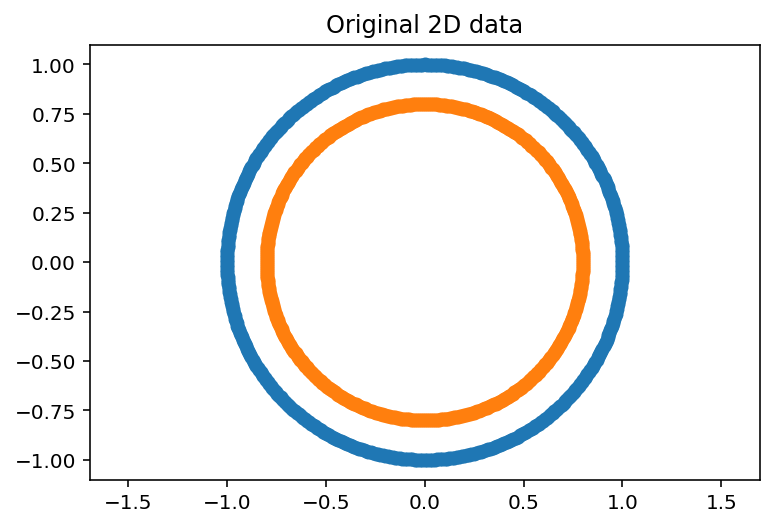

In [43]:
idx_0 = np.where(circles_labels==0)
idx_1 = np.where(circles_labels==1)
plt.scatter(circles_data[idx_0,0],circles_data[idx_0,1])
plt.scatter(circles_data[idx_1,0],circles_data[idx_1,1])
plt.axis('equal')
plt.title('Original 2D data')
plt.show()

#### Split datat into train and test

In [44]:
fracTrain = 0.8
fracTest = 1 - fracTrain

nTrain = int(nTot*fracTrain)
nTest = nTot - nTrain

In [45]:
nRounds = 3

In [46]:
repsTrain_solo = circles_data[:nTrain]
repsTest_solo = circles_data[nTrain:]

labelsTrain = circles_labels[:nTrain].astype(float)
labelsTest = circles_labels[nTrain:].astype(float)

In [47]:
dimProj = 10
A = np.random.rand(2,dimProj)

repsTrain_proj = repsTrain_solo@A
repsTest_proj = repsTest_solo@A

#### Make sequences

In [48]:
def makeSequences(dataset,Trounds=1):
    if Trounds==1:
        return np.expand_dims(dataset,1)
    elif Trounds>1:
        numSamps, numFeats = dataset.shape
        dataset_sequential = np.zeros((numSamps,Trounds,numFeats))
        for kk in range(Trounds):
            dataset_sequential[:,kk,:] = dataset
        return dataset_sequential

In [49]:
repsTrain = makeSequences(repsTrain_proj,nRounds)
print(repsTrain.shape)
repsTest = makeSequences(repsTest_proj,nRounds)
print(repsTest.shape)

(800, 3, 10)
(200, 3, 10)


#### Convert data to tensors

In [50]:
dataTrain = Variable(torch.from_numpy(repsTrain)).requires_grad_(True)
yTrain = Variable(torch.from_numpy(labelsTrain)).requires_grad_(True)

dataTest = Variable(torch.from_numpy(repsTest)).requires_grad_(True)
yTest = Variable(torch.from_numpy(labelsTest)).requires_grad_(True)

#### Train and test loaders

In [51]:
## create dataset and dataloader
tensorTrainData = TensorDataset(dataTrain,yTrain)
tensorTestData = TensorDataset(dataTest,yTest)

bs = 128 ## batch size
train_loader = DataLoader(tensorTrainData, batch_size=bs, shuffle=True)
train_loader_noShuffle = DataLoader(tensorTrainData, batch_size=bs, shuffle=False)
test_loader = DataLoader(tensorTestData, batch_size=bs, shuffle=False)

#### Test for CUDA

In [52]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('No GPU, training on CPU')
else:
    print('GPU found, training on GPU')

No GPU, training on CPU


#### MLP AE

In [53]:
n_latent = 2

In [54]:
class RNNpredictor(nn.Module):
    def __init__(self, seq_len=3, n_features=10, hidden_dim = 2):
        super(RNNpredictor, self).__init__()
        
        ##Encoder
        self.layer1 = nn.RNN(input_size = n_features, hidden_size = hidden_dim, num_layers = 1, batch_first = True)
        self.layer2 = nn.RNN(input_size = hidden_dim, hidden_size = n_features, num_layers = 1, batch_first = True)
#         self.layer2 = nn.Linear(5,2)
#         self.layer3 = nn.Linear(2, 5)
#         self.layer4 = nn.Linear(5,10)
        
#         self.dropout = nn.Dropout(0.3)
        
    def forward(self, x):
        #x = torch.unsqueeze(x,1)
        x1, hidden1 = self.layer1(x)
        #print(x1.shape)
        x2, hidden2 = self.layer2(x1)
        #print(x2.shape)
        
        return x2, hidden1

#create the NN
model = RNNpredictor()
print(model)

#move tensors to GPU if available
if train_on_gpu:
    model.cuda()

RNNpredictor(
  (layer1): RNN(10, 2, batch_first=True)
  (layer2): RNN(2, 10, batch_first=True)
)


#### Count number of parameters

In [55]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count_parameters(model)

168

#### Trial pass

In [56]:
#x.shape

In [57]:
for data, target in train_loader:
    if train_on_gpu:
        data, target = data.float().cuda(), target.float().cuda()
        recon, latent = model(data)
    data, target = data.float(), target.float()
    x_out2, hidden_out2 = model(data)

    

#### Train AE with MSE

#### Specify loss function and optimizer

In [58]:
#specify loss function
criterion = nn.MSELoss()

#optimizer
eta = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=eta)

data.shape


torch.Size([32, 3, 10])

#### Addresses to collect activations and models

In [59]:
# pp = 'Users\magicalkings\Final_project\tmp1\'
# npp = 'tmp2\'
# pp_npy = pp+npp+'npys/'
# pp_pts = pp+npp+'pts/'

#### Train the network

In [60]:
#number of epochs
n_epochs = 50
div = n_epochs//25 ## try ensuring that number used to divide by is a factor of n_epochs
train_losses = np.zeros(n_epochs)

train_loss_min = np.Inf
best_epoch = 0

for epoch in tqdm(range(1,n_epochs+1)):
    train_loss = 0.0
    cnt = 0
    
    #train model
    model.train()
    for data, target in train_loader:
        data, target = data.float(), target.float()
        if train_on_gpu:
            data, target = data.float().cuda(), target.float().cuda()
        
        optimizer.zero_grad() #clears older gradients
        output, _hidden = model(data) #forward pass
        loss = criterion(output[:,-1],data[:,-1].view(len(data),-1)) #calculate the loss for the batch
        loss.backward() #backprop
        optimizer.step() #update parameters in direction of the -ve gradient
        train_loss += loss.item()*data.size(0) #update training loss
        
    #calculate average loss
    train_loss = train_loss/len(train_loader.dataset)
    
    #training/validation stats
#     print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))
    train_losses[epoch-1] = train_loss
    
    #save model if the training loss decreased
    if train_loss <= train_loss_min:
        print('Epoch: {}, Train Loss Decreased!! ({:.6f}-->{:.6f})'.format(epoch,train_loss_min,train_loss))
        torch.save(model.state_dict(),'MLPAE.pt')
        train_loss_min = train_loss
        best_epoch = epoch
        
    if epoch%div == 0:
        torch.save(model.state_dict(), 'MLPAE_epoch_'+str(epoch)+'.pt')
        
        activations_hidden_np = np.zeros((nTest,n_latent))
        
        activations_out_np = np.zeros((nTest,dimProj))
        
        # track test loss
        test_loss = 0.0
        
        model.eval()
        for data_test, target_test in test_loader:
            if train_on_gpu:
                data_test, target_test = data_test.float().cuda(), target_test.float().cuda()
            data_test, target_test = data_test.float(), target_test.float()
            ## outputs
            output_test, act_hidden = model(data_test)
            
            # calculate the batch loss
            loss = criterion(output_test,data_test)
            
            # update test loss 
            test_loss += loss.item()*data_test.size(0)
            
            act_hidden = np.squeeze(act_hidden.detach().cpu().numpy())
            output_test = np.squeeze(output_test.detach().cpu().numpy())
            
            for i in range(bs):
                if i < len(data_test):
                    label = target_test.data[i]

                    activations_hidden_np[cnt] = act_hidden[i]

                    activations_out_np[cnt] = output_test[i,-1]

                    cnt += 1

        np.save('MLPAE_latent_epoch_'+str(epoch), activations_hidden_np)
        
        np.save('MLPAE_out_epoch_'+str(epoch), activations_out_np)
        
        # average test loss
        test_loss = test_loss/len(test_loader.dataset)
        print('Test Loss: {:.6f}\n'.format(test_loss))

  2%|▏         | 1/50 [00:00<00:07,  6.55it/s]

Epoch: 1, Train Loss Decreased!! (inf-->0.226331)
Epoch: 2, Train Loss Decreased!! (0.226331-->0.212463)
Test Loss: 0.204992



  8%|▊         | 4/50 [00:00<00:05,  7.86it/s]

Epoch: 3, Train Loss Decreased!! (0.212463-->0.200631)
Epoch: 4, Train Loss Decreased!! (0.200631-->0.189883)
Test Loss: 0.186861

Epoch: 5, Train Loss Decreased!! (0.189883-->0.179471)


 16%|█▌        | 8/50 [00:00<00:04,  9.56it/s]

Epoch: 6, Train Loss Decreased!! (0.179471-->0.168768)
Test Loss: 0.169707

Epoch: 7, Train Loss Decreased!! (0.168768-->0.157985)
Epoch: 8, Train Loss Decreased!! (0.157985-->0.146868)
Test Loss: 0.152158



 20%|██        | 10/50 [00:00<00:03, 10.63it/s]

Epoch: 9, Train Loss Decreased!! (0.146868-->0.135607)
Epoch: 10, Train Loss Decreased!! (0.135607-->0.124738)
Test Loss: 0.135006

Epoch: 11, Train Loss Decreased!! (0.124738-->0.114066)
Epoch: 12, Train Loss Decreased!! (0.114066-->0.104051)
Test Loss: 0.119092


 28%|██▊       | 14/50 [00:01<00:03, 11.53it/s]


Epoch: 13, Train Loss Decreased!! (0.104051-->0.094832)
Epoch: 14, Train Loss Decreased!! (0.094832-->0.086419)
Test Loss: 0.105499



 32%|███▏      | 16/50 [00:01<00:03,  9.46it/s]

Epoch: 15, Train Loss Decreased!! (0.086419-->0.078932)
Epoch: 16, Train Loss Decreased!! (0.078932-->0.072355)
Test Loss: 0.094727

Epoch: 17, Train Loss Decreased!! (0.072355-->0.066604)
Epoch: 18, Train Loss Decreased!! (0.066604-->0.061460)


 40%|████      | 20/50 [00:01<00:02, 11.03it/s]

Test Loss: 0.086299

Epoch: 19, Train Loss Decreased!! (0.061460-->0.056934)
Epoch: 20, Train Loss Decreased!! (0.056934-->0.052897)
Test Loss: 0.079818



 44%|████▍     | 22/50 [00:01<00:02, 11.59it/s]

Epoch: 21, Train Loss Decreased!! (0.052897-->0.049268)
Epoch: 22, Train Loss Decreased!! (0.049268-->0.046089)
Test Loss: 0.074907

Epoch: 23, Train Loss Decreased!! (0.046089-->0.043207)


 52%|█████▏    | 26/50 [00:02<00:01, 12.55it/s]

Epoch: 24, Train Loss Decreased!! (0.043207-->0.040702)
Test Loss: 0.071130

Epoch: 25, Train Loss Decreased!! (0.040702-->0.038517)
Epoch: 26, Train Loss Decreased!! (0.038517-->0.036516)
Test Loss: 0.068148



 60%|██████    | 30/50 [00:02<00:01, 13.70it/s]

Epoch: 27, Train Loss Decreased!! (0.036516-->0.034777)
Epoch: 28, Train Loss Decreased!! (0.034777-->0.033233)
Test Loss: 0.065832

Epoch: 29, Train Loss Decreased!! (0.033233-->0.031874)
Epoch: 30, Train Loss Decreased!! (0.031874-->0.030705)
Test Loss: 0.064075



 64%|██████▍   | 32/50 [00:02<00:01, 12.54it/s]

Epoch: 31, Train Loss Decreased!! (0.030705-->0.029650)
Epoch: 32, Train Loss Decreased!! (0.029650-->0.028726)
Test Loss: 0.062630

Epoch: 33, Train Loss Decreased!! (0.028726-->0.027900)


 72%|███████▏  | 36/50 [00:03<00:01, 12.30it/s]

Epoch: 34, Train Loss Decreased!! (0.027900-->0.027184)
Test Loss: 0.061696

Epoch: 35, Train Loss Decreased!! (0.027184-->0.026508)
Epoch: 36, Train Loss Decreased!! (0.026508-->0.025923)
Test Loss: 0.060860



 76%|███████▌  | 38/50 [00:03<00:01, 10.92it/s]

Epoch: 37, Train Loss Decreased!! (0.025923-->0.025371)
Epoch: 38, Train Loss Decreased!! (0.025371-->0.024856)
Test Loss: 0.060250



 80%|████████  | 40/50 [00:03<00:01,  9.09it/s]

Epoch: 39, Train Loss Decreased!! (0.024856-->0.024373)
Epoch: 40, Train Loss Decreased!! (0.024373-->0.023898)
Test Loss: 0.059797



 84%|████████▍ | 42/50 [00:03<00:00,  8.18it/s]

Epoch: 41, Train Loss Decreased!! (0.023898-->0.023453)
Epoch: 42, Train Loss Decreased!! (0.023453-->0.023021)
Test Loss: 0.059364



 86%|████████▌ | 43/50 [00:04<00:00,  7.22it/s]

Epoch: 43, Train Loss Decreased!! (0.023021-->0.022579)


 88%|████████▊ | 44/50 [00:04<00:01,  3.88it/s]

Epoch: 44, Train Loss Decreased!! (0.022579-->0.022149)
Test Loss: 0.058990



 90%|█████████ | 45/50 [00:04<00:01,  3.81it/s]

Epoch: 45, Train Loss Decreased!! (0.022149-->0.021698)


 92%|█████████▏| 46/50 [00:05<00:01,  3.54it/s]

Epoch: 46, Train Loss Decreased!! (0.021698-->0.021257)
Test Loss: 0.058629



 94%|█████████▍| 47/50 [00:05<00:00,  3.89it/s]

Epoch: 47, Train Loss Decreased!! (0.021257-->0.020799)


 98%|█████████▊| 49/50 [00:05<00:00,  4.19it/s]

Epoch: 48, Train Loss Decreased!! (0.020799-->0.020329)
Test Loss: 0.058313

Epoch: 49, Train Loss Decreased!! (0.020329-->0.019825)


100%|██████████| 50/50 [00:06<00:00,  8.33it/s]

Epoch: 50, Train Loss Decreased!! (0.019825-->0.019313)
Test Loss: 0.058039



Text(0, 0.5, 'MSE')

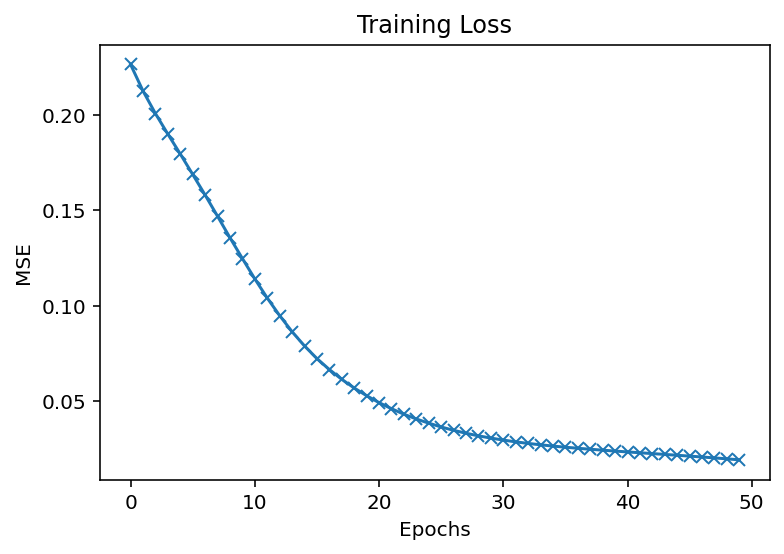

In [61]:
plt.plot((train_losses),'-x')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE')

#### Load best model

In [62]:
## best epoch = 50
print(best_epoch)

50


In [63]:
model.load_state_dict(torch.load('MLPAE.pt'))


<All keys matched successfully>

In [64]:
model.eval()

test_loss = 0.0
        
activations_latent_np = np.zeros((nTest,n_latent))
activations_out_np = np.zeros((nTest,dimProj))

cnt = 0

for data_test, target_test in test_loader:
    if train_on_gpu:
        data_test, target_test = data_test.float().cuda(), target_test.float().cuda()
    data_test, target_test = data_test.float(), target_test.float()
    ## outputs
    output_test, act_hidden = model(data_test)

    # calculate the batch loss
    loss = criterion(output_test, data_test)

    # update test loss 
    test_loss += loss.item()*data_test.size(0)

    act_hidden = np.squeeze(act_hidden.detach().cpu().numpy())
    output_test = np.squeeze(output_test.detach().cpu().numpy())

    for i in range(bs):
        if i < len(data_test):
            label = target_test.data[i]

            activations_hidden_np[cnt] = act_hidden[i]

            activations_out_np[cnt] = output_test[i,-1]

            cnt += 1

np.save('MLPAE_latent_epoch_'+str(best_epoch), activations_hidden_np)
np.save('MLPAE_out_epoch_'+str(best_epoch), activations_out_np)

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

Test Loss: 0.058039



In [65]:
model.eval()

train_loss = 0.0
        
activations_latent_train_np = np.zeros((nTrain,n_latent))
activations_out_train_np = np.zeros((nTrain,dimProj))

cnt = 0

for data_train, target_train in train_loader_noShuffle:
    if train_on_gpu:
        data_train, target_train = data_train.float().cuda(), target_train.float().cuda()
    data_train, target_train = data_train.float(), target_train.float()

    ## outputs
    output_train, act_hidden = model(data_train)

    # calculate the batch loss
    loss = criterion(output_train, data_train)

    # update train loss 
    train_loss += loss.item()*data_train.size(0)

    act_hidden = np.squeeze(act_hidden.detach().cpu().numpy())
    output_train = np.squeeze(output_train.detach().cpu().numpy())

    for i in range(bs):
        if i < len(data_train):
            label = target_train.data[i]

            activations_latent_train_np[cnt] = act_hidden[i]

            activations_out_train_np[cnt] = output_train[i,-1]

            cnt += 1

# np.save('MLPAE_latent_epoch_'+str(best_epoch), activations_hidden_np)
# np.save('MLPAE_out_epoch_'+str(best_epoch), activations_out_np)

# average train loss
train_loss = train_loss/len(train_loader.dataset)
print('Test Loss: {:.6f}\n'.format(train_loss))

Test Loss: 0.058844



#### Plot latent data

(-0.7636566579341888,
 1.0456527888774871,
 -0.7729068398475647,
 0.9584185481071472)

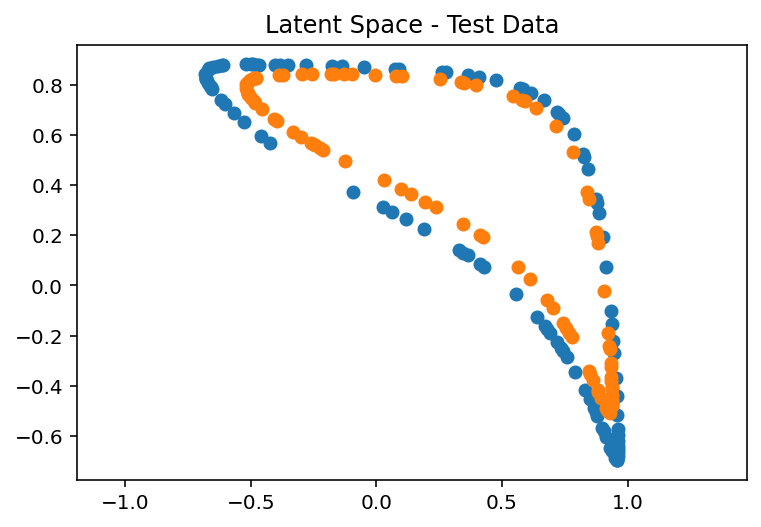

In [66]:
for ii in range(2):
    col = 'C' + str(ii)
    idx = np.where(labelsTest==ii)[0]
    plt.scatter(activations_hidden_np[idx,0],activations_hidden_np[idx,1],c=col)
plt.title('Latent Space - Test Data')
plt.axis('equal')

In [67]:
activations_hidden_np.shape


(200, 2)

In [68]:
# for ii in range(2):
#     col = 'C' + str(ii)
#     idx = np.where(labelsTrain==ii)[0]
#     plt.scatter(activations_latent_train_np[idx,0],activations_latent_train_np[idx,1],c=col)
# plt.title('Train data')

#### Train a linear classifier on top of latent representations

In [69]:
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier
from sklearn import svm

In [70]:
clf = Perceptron(tol=1e-3, random_state=22)
clf.fit(activations_latent_train_np, labelsTrain)
print('Train Accuracy = ',clf.score(activations_latent_train_np, labelsTrain))
print('Test Accuracy = ',clf.score(activations_hidden_np, labelsTest))
print(activations_latent_train_np.shape)

Train Accuracy =  0.49625
Test Accuracy =  0.515
(800, 2)


In [75]:
nRuns = 5
numTrainSamps = [10,25,50,100,200,300,400,500,600,700,800]
acc_list_train = np.zeros((nRuns,len(numTrainSamps)))
acc_list_test = np.zeros((nRuns,len(numTrainSamps)))

for ii in range(nRuns):
    for cnt, kk in enumerate(numTrainSamps):
            idxs = np.sort(np.random.choice(nTrain,kk,replace=False))
            clf_temp = Perceptron(tol=1e-3, random_state=22)
            clf_temp.fit(activations_latent_train_np[idxs], labelsTrain[idxs])
            acc_list_train[ii,cnt] = clf_temp.score(activations_latent_train_np[idxs], labelsTrain[idxs])
            acc_list_test[ii,cnt] = clf_temp.score(activations_hidden_np, labelsTest)

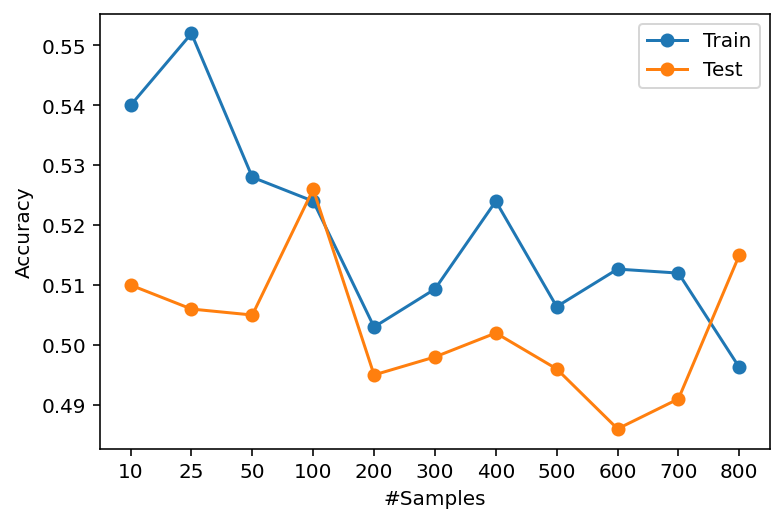

In [76]:
plt.plot(np.mean(acc_list_train,axis=0),'-o',label='Train')
plt.plot(np.mean(acc_list_test,axis=0),'-o',label='Test')
plt.legend()
plt.xticks(np.arange(len(numTrainSamps)),np.array(numTrainSamps))
plt.ylabel('Accuracy')
plt.xlabel('#Samples')
plt.show()

In [77]:
clf = MLPClassifier(random_state=22,max_iter=1000,hidden_layer_sizes=(20,3))
clf.fit(activations_latent_train_np, labelsTrain)
print('Train Accuracy = ',clf.score(activations_latent_train_np, labelsTrain))
print('Test Accuracy = ',clf.score(activations_hidden_np, labelsTest))
print(activations_latent_train_np.shape)

Train Accuracy =  0.82875
Test Accuracy =  0.815
(800, 2)


/Users/magicalkings/miniconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


In [80]:
clf = svm.SVC()
clf.fit(activations_latent_train_np, labelsTrain)
print('Train Accuracy = ',clf.score(activations_latent_train_np, labelsTrain))
print('Test Accuracy = ',clf.score(activations_hidden_np, labelsTest))
print(activations_latent_train_np.shape)

Train Accuracy =  0.70625
Test Accuracy =  0.675
(800, 2)


In [78]:
nRuns = 5
numTrainSamps = [10,25,50,100,200,300,400,500,600,700,800]
acc_list_train = np.zeros((nRuns,len(numTrainSamps)))
acc_list_test = np.zeros((nRuns,len(numTrainSamps)))

for ii in range(nRuns):
    for cnt, kk in enumerate(numTrainSamps):
            idxs = np.sort(np.random.choice(nTrain,kk,replace=False))
            clf_temp = MLPClassifier(random_state=22,max_iter=1000,hidden_layer_sizes=(20,3))
            clf_temp.fit(activations_latent_train_np[idxs], labelsTrain[idxs])
            acc_list_train[ii,cnt] = clf_temp.score(activations_latent_train_np[idxs], labelsTrain[idxs])
            acc_list_test[ii,cnt] = clf_temp.score(activations_hidden_np, labelsTest)

/Users/magicalkings/miniconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/magicalkings/miniconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/magicalkings/miniconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/magicalkings/miniconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Use

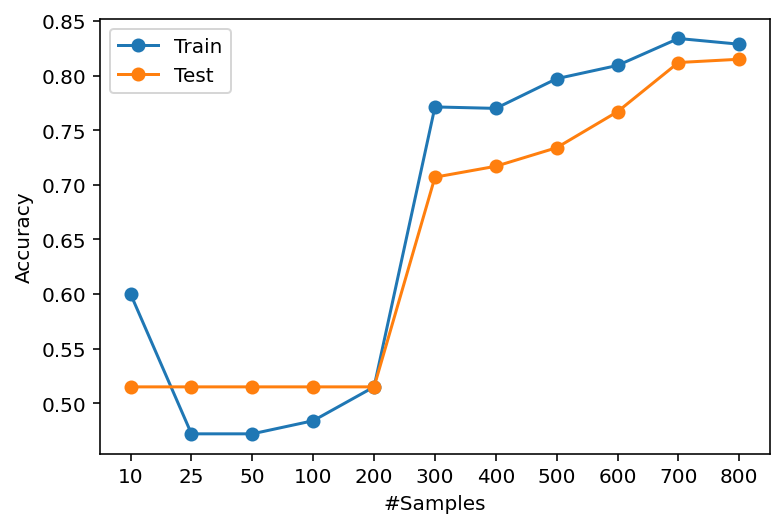

In [79]:
plt.plot(np.mean(acc_list_train,axis=0),'-o',label='Train')
plt.plot(np.mean(acc_list_test,axis=0),'-o',label='Test')
plt.legend()
plt.xticks(np.arange(len(numTrainSamps)),np.array(numTrainSamps))
plt.ylabel('Accuracy')
plt.xlabel('#Samples')
plt.show()

In [81]:
nRuns = 5
numTrainSamps = [10,25,50,100,200,300,400,500,600,700,800]
acc_list_train = np.zeros((nRuns,len(numTrainSamps)))
acc_list_test = np.zeros((nRuns,len(numTrainSamps)))

for ii in range(nRuns):
    for cnt, kk in enumerate(numTrainSamps):
            idxs = np.sort(np.random.choice(nTrain,kk,replace=False))
            clf_temp = svm.SVC()
            clf_temp.fit(activations_latent_train_np[idxs], labelsTrain[idxs])
            acc_list_train[ii,cnt] = clf_temp.score(activations_latent_train_np[idxs], labelsTrain[idxs])
            acc_list_test[ii,cnt] = clf_temp.score(activations_hidden_np, labelsTest)

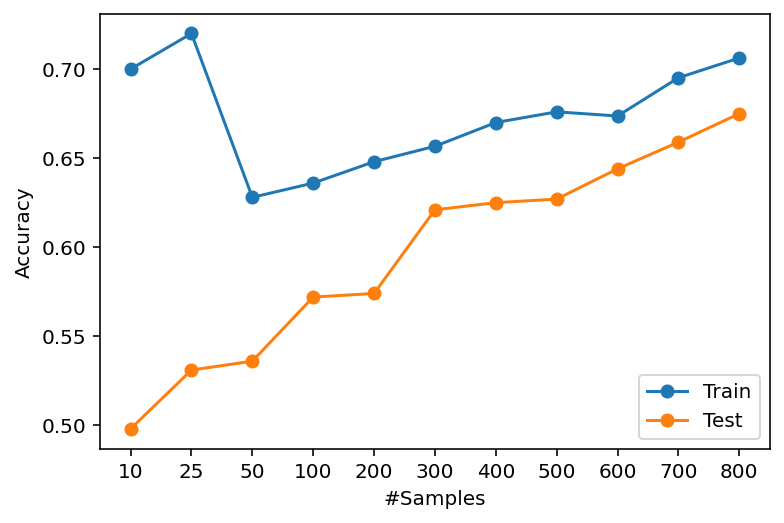

In [83]:
plt.plot(np.mean(acc_list_train,axis=0),'-o',label='Train')
plt.plot(np.mean(acc_list_test,axis=0),'-o',label='Test')
plt.legend()
plt.xticks(np.arange(len(numTrainSamps)),np.array(numTrainSamps))
plt.ylabel('Accuracy')
plt.xlabel('#Samples')
plt.show()